In [39]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 33°C,   0 % |  5534 / 81920 MB | murillor(1278M) jiseonm(4254M)
  [1] NVIDIA A100 80GB PCIe | 30°C,   0 % |  1288 / 81920 MB | murillor(1286M)
  [2] NVIDIA A100 80GB PCIe | 28°C,   0 % |     2 / 81920 MB |
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
base_folder = "spatial_sim_data"
labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N", "n", "nPO"])
print(labels)

                                        path      N    n  nPO
0      images/spatial_sim_parents_1000_0_500   1020  500   90
1      images/spatial_sim_parents_1000_1_500   1007  500  127
2      images/spatial_sim_parents_1000_2_500   1009  500  138
3      images/spatial_sim_parents_1000_3_500   1006  500  121
4      images/spatial_sim_parents_1000_4_500   1007  500  124
...                                      ...    ...  ...  ...
2425  images/spatial_sim_parents_9900_22_500  10028  500   67
2426  images/spatial_sim_parents_9900_23_500  10041  500   66
2427  images/spatial_sim_parents_9900_24_500  10005  500   69
2428  images/spatial_sim_parents_9900_25_500  10067  500   54
2429  images/spatial_sim_parents_9900_26_500  10041  500   52

[2430 rows x 4 columns]


In [5]:
idx = 0
base_path = base_folder + "/" + labels['path'].iloc[0]
spaghetti_path = base_path + "_spaghetti.png"
samples_path = base_path + "_samples.png"
print(spaghetti_path)
print(samples_path)
spaghetti = read_image(spaghetti_path)
samples = read_image(samples_path)

spatial_sim_data/images/spatial_sim_parents_1000_0_500_spaghetti.png
spatial_sim_data/images/spatial_sim_parents_1000_0_500_samples.png


In [6]:
print(spaghetti.size())
print(samples.size())
# Number of samples, should be 500
print(samples.sum()/255)
images = torch.cat((spaghetti, samples), 0)
print(images.size())

torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
tensor(500.)
torch.Size([2, 500, 500])


In [47]:
class KinDataset(Dataset):
    def __init__(self, base_folder):
        self.labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N", "n", "nPO"])
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        base_path = self.base_folder + "/" + self.labels['path'].iloc[idx]
        spaghetti_path = base_path + "_spaghetti.png"
        samples_path = base_path + "_samples.png"
        spaghetti = read_image(spaghetti_path)
        samples = read_image(samples_path)
        input_tensor = torch.cat((spaghetti, samples), 0).float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("spatial_sim_data")

In [48]:
print(kin_dataset[2][0].size())
print(kin_dataset[2][1])
print(kin_dataset[100][1])

torch.Size([2, 500, 500])
tensor([1009.])
tensor([1340.])


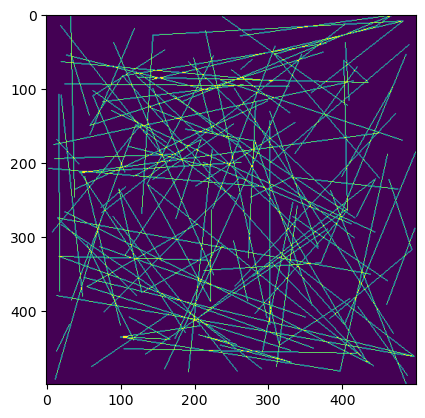

In [49]:
plt.imshow(kin_dataset[2][0][0])

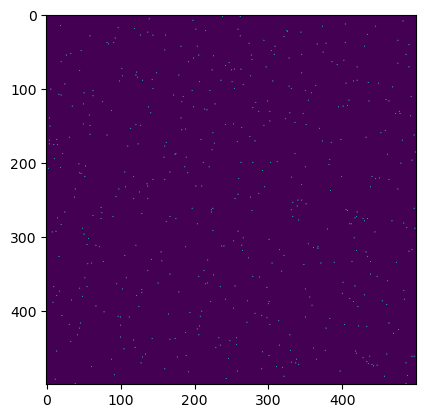

In [50]:
plt.imshow(kin_dataset[2][0][1])

In [51]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [52]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

1215
608
607


In [54]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2)) 

In [56]:
x = torch.ones((4, 2, 500, 500))
model(x).shape

torch.Size([4, 64, 125, 125])

In [58]:
model.add_module('flatten', nn.Flatten()) 
model(x).shape

torch.Size([4, 1000000])

In [59]:
model.add_module('fc1', nn.Linear(1000000, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 
model.add_module('fc2', nn.Linear(1024, 1)) 

In [60]:
model(x).shape

torch.Size([4, 1])

In [61]:
model = model.to(device) 

In [62]:
loss_fn = nn.HuberLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 8861.7222 val_loss: 5584.1556
Epoch 2 loss: 5490.3631 val_loss: 5550.3447
Epoch 3 loss: 5211.0356 val_loss: 3922.2584
Epoch 4 loss: 2843.9231 val_loss: 2447.9293
Epoch 5 loss: 2407.5041 val_loss: 2457.4362
Epoch 6 loss: 2205.3163 val_loss: 2390.2750
Epoch 7 loss: 1996.7648 val_loss: 2356.9538
Epoch 8 loss: 1691.6067 val_loss: 2401.0764
Epoch 9 loss: 1202.2847 val_loss: 2288.2360
Epoch 10 loss: 887.5404 val_loss: 2294.7255
Epoch 11 loss: 708.4882 val_loss: 2319.6327
Epoch 12 loss: 639.5367 val_loss: 2318.0942
Epoch 13 loss: 554.1735 val_loss: 2348.5019
Epoch 14 loss: 540.8721 val_loss: 2315.9580
Epoch 15 loss: 495.9296 val_loss: 2327.5693
Epoch 16 loss: 522.3751 val_loss: 2321.5734
Epoch 17 loss: 493.7727 val_loss: 2322.6070
Epoch 18 loss: 469.8640 val_loss: 2322.0466
Epoch 19 loss: 476.5537 val_loss: 2311.2028
Epoch 20 loss: 472.3714 val_loss: 2333.0830


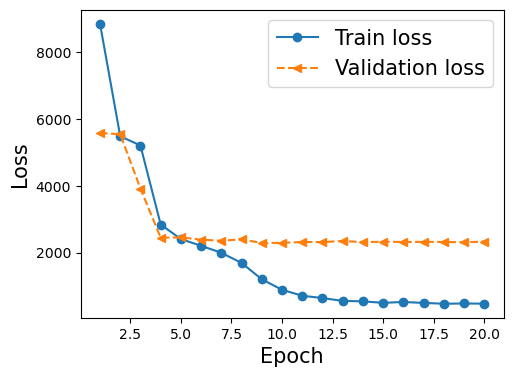

In [63]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [64]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        #test_pred[i] = test_output.numpy()
        #test_truth[i] = test_output[0].numpy()
        #test_pred[i] = model(test_input)[0, 0].numpy()

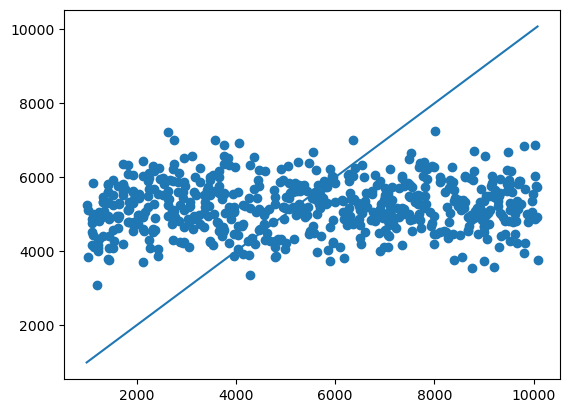

In [68]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [69]:
np.mean(test_truth)

5468.186161449753